<a href="https://colab.research.google.com/github/MohibShaikh/Comment-Toxicity-Classifier/blob/main/Comment_Toxicity_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'jigsaw-toxic-comment-classification-challenge:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1709138%2F2798066%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240408%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240408T192753Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dadc1085854465fa46be8347449669632aacf2473fd45b99b7800a0b3e298f7a31a595ec59d7a57d3062464198a1c994283f6aa8495bda4aca9fee21b1650aa5201a848404618700cf41a7c5c7e79f551de3e7a123b1cc44f2fe0711eac6a246a5b339bdde3cccfbbd08efe76706ca7e30bdd6712b20e938604fff808c41e9c671459db01378e76f6460679f9da31c93c2f178e2fa8311ecdd5811fddb3c7fbe52c9b79a1bb57c9a19107aa9a6fd7fb5bbe7c4d9d9e56dfaa28d4e9892fc3a4d1736f6cb1fa891f47dd4998822b719a1a7e7d2caefd1f2c73b3d4cecfb349481cc5f9e6dcad36316d1b1e32ce3b1aeb28255cad1a754afdae986b48a82cf35601'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 55956177 bytes downloaded
Downloaded and uncompressed: jigsaw-toxic-comment-classification-challenge
Data source import complete.


In [3]:
!pip install tensorflow

In [5]:
import pandas as pd
import tensorflow as tf
import numpy as np

In [6]:
df = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv')

In [7]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [8]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [9]:
MAX_FEATURES = 200000 # NUMBER Of words in the vocab

In [10]:
from tensorflow.keras.layers import TextVectorization
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [11]:
vectorizer.adapt(X.values)
vectorized_text = vectorizer(X.values)

In [12]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [48]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

## Creating Sequential Model

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout

In [50]:
model = Sequential()
# Create the embedding layer
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer
model.add(Dense(6, activation='sigmoid'))

In [51]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [52]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          6400032   
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                16640     
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 6)                 774       
                                                      

In [57]:
history = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
6981/6981 [==============================] - 715s 102ms/step - loss: 0.0520 - val_loss: 0.0457
Epoch 2/10
6981/6981 [==============================] - 690s 99ms/step - loss: 0.0446 - val_loss: 0.0387
Epoch 3/10
6981/6981 [==============================] - 679s 97ms/step - loss: 0.0391 - val_loss: 0.0343
Epoch 4/10
6981/6981 [==============================] - 694s 99ms/step - loss: 0.0353 - val_loss: 0.0314
Epoch 5/10
6981/6981 [==============================] - 704s 101ms/step - loss: 0.0318 - val_loss: 0.0280
Epoch 6/10
6981/6981 [==============================] - 694s 99ms/step - loss: 0.0282 - val_loss: 0.0241
Epoch 7/10
6981/6981 [==============================] - 692s 99ms/step - loss: 0.0256 - val_loss: 0.0222
Epoch 8/10
6981/6981 [==============================] - 679s 97ms/step - loss: 0.0229 - val_loss: 0.0202
Epoch 9/10
6981/6981 [==============================] - 682s 98ms/step - loss: 0.0205 - val_loss: 0.0185
Epoch 10/10
6981/6981 [==============================

<Figure size 800x500 with 0 Axes>

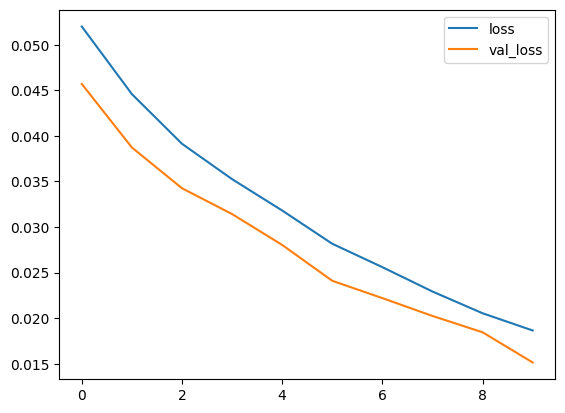

In [58]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

## Making Predictions

In [59]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [60]:
input_text = vectorizer('I am going to nag you!')


In [61]:
res = model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 16s 16s/step


In [62]:
(res > 0.5).astype(int)

array([[1, 0, 0, 0, 0, 0]])

In [63]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 121ms/step


array([[1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [64]:
res.shape

(1, 6)

## Evaluating Model

In [77]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy, Accuracy

In [78]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()
accu2 = Accuracy()

In [79]:
for batch in test.as_numpy_iterator():
    # Unpack the batch
    X_true, y_true = batch
    # Make a prediction
    yhat = model.predict(X_true)

    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()

    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)
    accu2.update_state(y_true, yhat)


1/1 [==============================] - 0s 57ms/step


In [84]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Categorical Accuracy:{acc.result().numpy()}, Accuracy:{accu2.result().numpy()}')

Precision: 0.90021812915802, Recall:0.9383347630500793, Categorical Accuracy:0.5175526738166809, Accuracy:0.014303326606750488


## Testing and Gradio Implementation

In [69]:
!pip install gradio
!pip install jinja2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 kB 14.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 89.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 10.0 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.2-py3-none-any.whl si

In [70]:
import tensorflow as tf
import gradio as gr

In [71]:
model.save('toxicity.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [72]:
model = tf.keras.models.load_model('toxicity.h5')

In [73]:
input_str = vectorizer('hey i flipping despise you!')

In [74]:
res = model.predict(np.expand_dims(input_str,0))
res

1/1 [==============================] - 1s 1s/step


array([[3.2439679e-01, 2.0609284e-06, 1.0682358e-02, 5.2732055e-04,
        1.8306315e-02, 6.8891759e-04]], dtype=float32)

In [75]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)

    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)

    return text

In [87]:
interface = gr.Interface(fn=score_comment, inputs="textbox",outputs='text')

In [88]:
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://7114234dccc9bb8a8e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
